In [1]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import pandas as pd
import ipywidgets as widgets
from IPython.html.widgets import *
import pickle
import h5py
import time

/usr/local/lib/python3.6/dist-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
train_meta = pd.read_csv('/content/gdrive/My Drive/ColabNotebook/comma/train_meta.csv')
print('shape: ', train_meta.shape)

shape:  (20400, 3)


In [4]:


def train_valid_split(dframe, seed_val):
    """
    Randomly shuffle pairs of rows in the dataframe, separates train and validation data
    generates a uniform random variable 0->9, gives 20% chance to append to valid data, otherwise train_data
    return tuple (train_data, valid_data) dataframes
    """
    train_data = pd.DataFrame()
    valid_data = pd.DataFrame()
    np.random.seed(seed_val)
    for i in tqdm(range(len(dframe) - 1)):
        idx1 = np.random.randint(len(dframe) - 1)
        idx2 = idx1 + 1
        
        
        row1 = dframe.iloc[[idx1]].reset_index()
        row2 = dframe.iloc[[idx2]].reset_index()
        
        randInt = np.random.randint(9)
        if randInt <= 1:
            valid_frames = [valid_data, row1, row2]
            valid_data = pd.concat(valid_frames, axis = 0, join = 'outer', ignore_index=False)
        if randInt >= 2:
            train_frames = [train_data, row1, row2]
            train_data = pd.concat(train_frames, axis = 0, join = 'outer', ignore_index=False)
    return train_data, valid_data

In [5]:
seeds = [0]

In [6]:

train_data, valid_data = train_valid_split(train_meta, seeds[0])

100%|██████████| 20399/20399 [01:14<00:00, 275.50it/s]


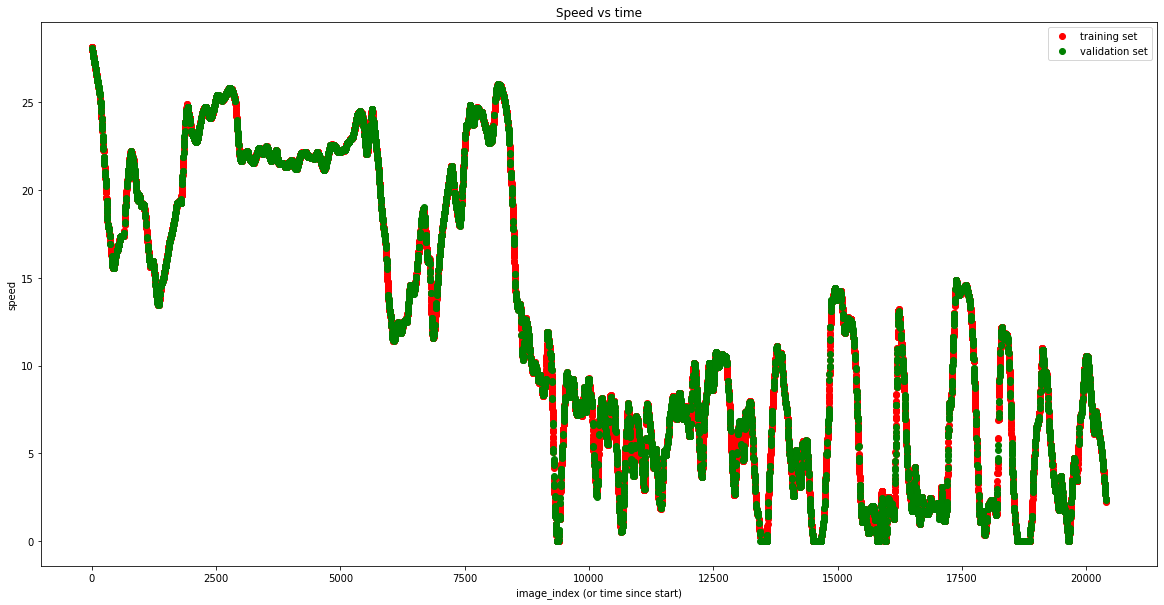

----
valid_data:  (8946, 4)
train_data:  (31852, 4)


In [7]:
fig, ax = plt.subplots(figsize=(20,10))
plt.plot(train_data.sort_values(['image_index'])[['image_index']], train_data.sort_values(['image_index'])[['speed']], 'ro')
plt.plot(valid_data.sort_values(['image_index'])[['image_index']], valid_data.sort_values(['image_index'])[['speed']], 'go')
plt.xlabel('image_index (or time since start)')
plt.ylabel('speed')
plt.title('Speed vs time')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()
plt.close()

print('----')
print('valid_data: ', valid_data.shape)
print('train_data: ', train_data.shape)

In [8]:
def change_brightness(image, bright_factor):
    """
    Augments the brightness of the image by multiplying the saturation by a uniform random variable
    Input: image (RGB)
    returns: image with brightness augmentation
    """
    
    hsv_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    # perform brightness augmentation only on the second channel
    hsv_image[:,:,0] = hsv_image[:,:,0] * bright_factor
    
    # change back to RGB
    image_rgb = cv2.cvtColor(hsv_image, cv2.COLOR_HSV2RGB)
    return image_rgb

In [9]:
# img=mpimg.imread(train_meta['image_path'][60])
# print('original image shape:', img.shape)
# plt.imshow(img)
# plt.show()
# plt.close()

# bright_factor = 0.7 + np.random.uniform()
# print('bright_factor:', bright_factor)
# print('brightned image')
# img=mpimg.imread(train_meta['image_path'][60])
# plt.imshow(change_brightness(img, bright_factor))
# plt.show()
# plt.close()

In [10]:
def preprocess_image(image):
    """
    preprocesses the image
    
    input: image (480 (y), 640 (x), 3) RGB
    output: image (shape is (220, 66, 3) as RGB)
    
    This stuff is performed on my validation data and my training data
    Process: 
             1) Cropping out black spots
             3) resize to (220, 66, 3) if not done so already from perspective transform
    """
    # Crop out sky (top) (100px) and black right part (-90px)
    #image_cropped = image[100:440, :-90] # -> (380, 550, 3) #v2 for data
    image_cropped = image[25:375, :] #v1 for data
    
    image = cv2.resize(image_cropped, (220, 66), interpolation = cv2.INTER_AREA)
    
    return image


In [11]:
def image_difference(first_frame, second_frame):

  first_gray = cv2.cvtColor(first_frame, cv2.COLOR_RGB2GRAY)
  second_gray = cv2.cvtColor(second_frame, cv2.COLOR_RGB2GRAY)

  first_gray = cv2.GaussianBlur(first_gray, (5, 5), 0)

  second_gray = cv2.GaussianBlur(second_gray, (5, 5), 0)

  difference = cv2.absdiff(first_gray, second_gray)
  _, difference = cv2.threshold(difference, 25, 255, cv2.THRESH_BINARY)

  #difference = cv2.bitwise_not(difference)

  difference = cv2.normalize(difference, None, norm_type=cv2.NORM_MINMAX)
  print(difference.shape)

  return difference    


In [12]:
def preprocess_image_valid_from_path(image_path, speed):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = preprocess_image(img)
    return img, speed

def preprocess_image_from_path(image_path, speed, bright_factor):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = change_brightness(img, bright_factor)    
    img = preprocess_image(img)
    return img, speed

In [13]:
def opticalFlowDense(image_current, image_next):
    """
    input: image_current, image_next (RGB images)
    calculates optical flow magnitude and angle and places it into HSV image
    * Set the saturation to the saturation value of image_next
    * Set the hue to the angles returned from computing the flow params
    * set the value to the magnitude returned from computing the flow params
    * Convert from HSV to RGB and return RGB image with same size as original image
    """
    gray_current = cv2.cvtColor(image_current, cv2.COLOR_RGB2GRAY)
    gray_next = cv2.cvtColor(image_next, cv2.COLOR_RGB2GRAY)
    
    
    hsv = np.zeros((66, 220, 3))
    # set saturation
    hsv[:,:,1] = cv2.cvtColor(image_next, cv2.COLOR_RGB2HSV)[:,:,1]
 
    # Flow Parameters
#     flow_mat = cv2.CV_32FC2
    flow_mat = None
    image_scale = 0.5
    nb_images = 1
    win_size = 15
    nb_iterations = 2
    deg_expansion = 5
    STD = 1.3
    extra = 0

    # obtain dense optical flow paramters
    flow = cv2.calcOpticalFlowFarneback(gray_current, gray_next,  
                                        flow_mat, 
                                        image_scale, 
                                        nb_images, 
                                        win_size, 
                                        nb_iterations, 
                                        deg_expansion, 
                                        STD, 
                                        0)
                                        
        
    # convert from cartesian to polar
    mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])  
        
    # hue corresponds to direction
    hsv[:,:,0] = ang * (180/ np.pi / 2)
    
    # value corresponds to magnitude
    hsv[:,:,2] = cv2.normalize(mag,None,0,255,cv2.NORM_MINMAX)
    
    # convert HSV to float32's
    hsv = np.asarray(hsv, dtype= np.float32)
    rgb_flow = cv2.cvtColor(hsv,cv2.COLOR_HSV2RGB)

    
    return rgb_flow

In [14]:
def generate_training_data(data, batch_size = 32):

    rgb_image_batch = np.zeros((batch_size, 66, 220, 3))
    gray_image_batch = np.zeros((batch_size, 66, 220, 1)) # nvidia input params
    label_batch = np.zeros((batch_size))
    while True:   
        for i in range(batch_size):
            # generate a random index with a uniform random distribution from 1 to len - 1
            idx = np.random.randint(1, len(data) - 1)
            
            # Generate a random bright factor to apply to both images
            bright_factor = 0.2 + np.random.uniform()

            row_now = data.iloc[[idx]].reset_index()
            row_prev = data.iloc[[idx - 1]].reset_index()
            row_next = data.iloc[[idx + 1]].reset_index()
            
            # Find the 3 respective times to determine frame order (current -> next)
            
            time_now = row_now['image_index'].values[0]
            time_prev = row_prev['image_index'].values[0]
            time_next = row_next['image_index'].values[0]
            
            if abs(time_now - time_prev) == 1 and time_now > time_prev:
                row1 = row_prev
                row2 = row_now
                
            elif abs(time_next - time_now) == 1 and time_next > time_now:
                row1 = row_now
                row2 = row_next
            else:
                print('Error generating row')            
            
            x1, y1 = preprocess_image_from_path(row1['image_path'].values[0],
                                                row1['speed'].values[0],
                                               bright_factor)
            #print(y1)
            
            # preprocess another image
            x2, y2 = preprocess_image_from_path(row2['image_path'].values[0], 
                                                row2['speed'].values[0],
                                               bright_factor)
            #print(y2)
           
            # compute optical flow send in images as RGB


            rgb_diff = opticalFlowDense(x1, x2)

            rgb_image_batch[i] = rgb_diff


            cv_diff = image_difference(x1, x2)
            cv_diff = cv_diff.reshape(cv_diff.shape[0], cv_diff.shape[1], 1)

            # calculate mean speed
            y = np.mean([y1, y2])
            

            gray_image_batch[i] = cv_diff
            label_batch[i] = y

        yield shuffle(rgb_image_batch, gray_image_batch, label_batch)

In [15]:
def generate_validation_data(data):
    print(len(data))

    for idx in range(1, len(data) - 1): # start from the second row because we may try to grab it and need its prev to be in bounds

        row_now = data.iloc[[idx]].reset_index()
        row_prev = data.iloc[[idx - 1]].reset_index()
        row_next = data.iloc[[idx + 1]].reset_index()
        
        # Find the 3 respective times to determine frame order (current -> next)
        
        time_now = row_now['image_index'].values[0]
        time_prev = row_prev['image_index'].values[0]
        time_next = row_next['image_index'].values[0]
        
        if abs(time_now - time_prev) == 1 and time_now > time_prev:
            row1 = row_prev
            row2 = row_now
            
        elif abs(time_next - time_now) == 1 and time_next > time_now:
            row1 = row_now
            row2 = row_next
        else:
            print('Error generating row')        
        
        x1, y1 = preprocess_image_valid_from_path(row1['image_path'].values[0], row1['speed'].values[0])
        x2, y2 = preprocess_image_valid_from_path(row2['image_path'].values[0], row2['speed'].values[0])

      
        img_diff = opticalFlowDense(x1, x2)
        img_diff = img_diff.reshape(1, img_diff.shape[0], img_diff.shape[1], img_diff.shape[2])


        cv_diff = image_difference(x1, x2)
        cv_diff = cv_diff.reshape(1, cv_diff.shape[0], cv_diff.shape[1], 1)


        y = np.mean([y1, y2])        
        speed = np.array([[y]])

        yield img_diff, cv_diff, speed

In [16]:
# check pytorch version
import torch
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout, ELU, MSELoss, Tanh
from torch.optim import Adam, SGD
from torch.utils.tensorboard import SummaryWriter
%load_ext tensorboard
writer = SummaryWriter()

In [19]:
class Net(Module):   
    def __init__(self):
        super(Net, self).__init__()

        self.cnn_layers = Sequential(
            # Defining a 2D convolution layer
            Conv2d(in_channels=3, out_channels=32, kernel_size=5, stride=2),
            Tanh(),
            Conv2d(in_channels=32, out_channels=64, kernel_size=5, stride=2),
            Tanh(),
            Conv2d(in_channels=64, out_channels=112, kernel_size=5, stride=2),
            Tanh(),
            Dropout(),
            Conv2d(in_channels=112, out_channels=256, kernel_size=3, stride=1),
            Tanh(),
            Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1)
        )
        self.cnn_layers_gray = Sequential(
            # Defining a 2D convolution layer
            Conv2d(in_channels=1, out_channels=32, kernel_size=5, stride=2),
            ReLU(),
            Conv2d(in_channels=32, out_channels=64, kernel_size=5, stride=2),
            ReLU(),
            Conv2d(in_channels=64, out_channels=112, kernel_size=5, stride=2),
            ReLU(),
            Dropout(),
            Conv2d(in_channels=112, out_channels=256, kernel_size=3, stride=1),
            ReLU(),
            Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1)
        )
        self.linear_layers = Sequential(
            Linear(in_features=5120, out_features=1024),
            ReLU(),  
            Linear(in_features=1024, out_features=540),
            ReLU(),           
            Linear(in_features=540, out_features=256),
            ReLU(),    
            Linear(in_features=256, out_features=112),
            ReLU(),
            Linear(in_features=112, out_features=64),
            ReLU(),
            Linear(in_features=64, out_features=10),
            ReLU(),
            Linear(in_features=10, out_features=1)     
        )

    # Defining the forward pass    
    def forward(self, x1, x2):
        x1 = self.cnn_layers(x1)
        x2 = self.cnn_layers_gray(x2)
        print(x1.shape, x2.shape)
        x = torch.cat((x1, x2))
        print(x.shape)

        x = x.contiguous().view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

In [20]:

# defining the model
model = Net()
# defining the optimizer
optimizer = Adam(model.parameters(), lr=0.001)
# defining the loss function
criterion = MSELoss()
# checking if GPU is available
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()
    
from torchsummary import summary

x = torch.randn([1,3,66,220])

summary(model, [(3,66,220), (1,66,220)])

torch.Size([2, 256, 1, 20]) torch.Size([2, 256, 1, 20])
torch.Size([4, 256, 1, 20])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 32, 31, 108]           2,432
              Tanh-2          [-1, 32, 31, 108]               0
            Conv2d-3           [-1, 64, 14, 52]          51,264
              Tanh-4           [-1, 64, 14, 52]               0
            Conv2d-5           [-1, 112, 5, 24]         179,312
              Tanh-6           [-1, 112, 5, 24]               0
           Dropout-7           [-1, 112, 5, 24]               0
            Conv2d-8           [-1, 256, 3, 22]         258,304
              Tanh-9           [-1, 256, 3, 22]               0
           Conv2d-10           [-1, 256, 1, 20]         590,080
           Conv2d-11          [-1, 32, 31, 108]             832
             ReLU-12          [-1, 32, 31, 108]               0
           Conv2d-1

In [21]:
def prepare_batch_training_data(rgb_train, gray_train, y_train):
    rgb_train  = np.transpose(rgb_train, (0, 3, 1, 2))
    gray_train  = np.transpose(gray_train, (0, 3, 1, 2))

    rgb_train = torch.from_numpy(rgb_train) 
    gray_train = torch.from_numpy(gray_train) 

    y_train = torch.from_numpy(y_train) 

    return rgb_train, gray_train, y_train



def prepare_batch_validation_data(rgb_val, gray_val, y_val):   
    rgb_val  = np.transpose(rgb_val, (0, 3, 1, 2))
    gray_val  = np.transpose(gray_val, (0, 3, 1, 2))   

    gray_val = torch.from_numpy(gray_val) 
    rgb_val = torch.from_numpy(rgb_val)

    y_val = torch.from_numpy(y_val) 
    
    return rgb_train, gray_train, y_val

In [22]:
'''
TIP: This training could take several hours depending on how many iterations you chose in the .cfg file. 
You will want to let this run as you sleep or go to work for the day, etc. However, Colab Cloud Service kicks you off it's VMs if you are idle for too long (30-90 mins).
To avoid this hold (CTRL + SHIFT + i) at the same time to open up the inspector view on your browser.
Paste the following code into your console window and hit Enter.

For MacBook:  hold (command+shift+c) 

function ClickConnect(){
console.log("Working"); 
document
  .querySelector('#top-toolbar > colab-connect-button')
  .shadowRoot.querySelector('#connect')
  .click() 
}
setInterval(ClickConnect,60000)


'''


'\nTIP: This training could take several hours depending on how many iterations you chose in the .cfg file. \nYou will want to let this run as you sleep or go to work for the day, etc. However, Colab Cloud Service kicks you off it\'s VMs if you are idle for too long (30-90 mins).\nTo avoid this hold (CTRL + SHIFT + i) at the same time to open up the inspector view on your browser.\nPaste the following code into your console window and hit Enter.\n\nFor MacBook:  hold (command+shift+c) \n\nfunction ClickConnect(){\nconsole.log("Working"); \ndocument\n  .querySelector(\'#top-toolbar > colab-connect-button\')\n  .shadowRoot.querySelector(\'#connect\')\n  .click() \n}\nsetInterval(ClickConnect,60000)\n\n\n'

In [ ]:


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# defining the number of epochs
n_epochs = 20
# empty list to store training losses
train_losses = []
# empty list to store validation losses
val_losses = []
# training the model
train_batch_counter = 0
val_batch_counter = 0
batch_size = 32

for epoch in range(1, n_epochs+1):
  epoch_start = time.time()
  print("Epoch   :", epoch)
  training = generate_training_data(train_data, batch_size)
  model.train()  


  for batch in tqdm(training):
    batch_start = time.time()
    train_batch_counter = train_batch_counter+1
    tr_loss = 0
    rgb_images, gray_images, speed = batch
    print(rgb_images.shape)

    rgb_train, gray_train, y_train = prepare_batch_training_data(rgb_images, gray_images, speed)

    # converting the data into GPU format
    
    rgb_train = rgb_train.float().to(device)
    gray_train = gray_train.float().to(device)
    y_train = y_train.float().to(device)


    # clearing the Gradients of the model parameters
    optimizer.zero_grad()
    
    # prediction for training and validation set

    
    output_train = model(rgb_train, gray_train)

    # computing the training and validation loss
    loss_train = criterion(output_train, y_train)
    print("train_loss", loss_train.item())
    train_losses.append(loss_train.item())

    writer.add_scalar("Loss/train", loss_train, epoch)

    # computing the updated weights of all the model parameters
    loss_train.backward()
    optimizer.step()
    tr_loss = loss_train.item()

    print((time.time() - batch_start), " seconds taken for last batch")


    if train_batch_counter % 1 == 0:

      torch.save(model.state_dict(), '/content/gdrive/My Drive/ColabNotebook/comma/models2/comma_model_'+str(train_batch_counter)+'.pth') 
      print("saved state dict after training on ", train_batch_counter, " batches")

  
    if train_batch_counter % 1 == 0:
      model.eval()

      validation = generate_validation_data(valid_data)
      for batch in validation:
        val_batch_counter+=1
        rgb_image, gray_image, speed = batch
        rgb_val, gray_val, y_val = prepare_batch_validation_data(rgb_image, gray_image, speed)


        with torch.no_grad():
            rgb_val = rgb_val.float().to(device)
            gray_val = gray_val.float().to(device)
            y_val = y_val.float().to(device)

            output_val = model(rgb_val, gray_val)
            
            loss_val = criterion(output_val, y_val)
            print("val_loss", loss_val)
            val_losses.append(loss_val.item())
            writer.add_scalar("Loss/val", loss_val, val_batch_counter)
        print("Validation going on ", val_batch_counter, " samples")

      

  print((time.time() - batch_start), " seconds taken for last epoch ie.: ", epoch)



writer.flush()
# Call flush() method to make sure that all pending events have been written to disk
writer.close()
# If you do not need the summary writer anymore, call close() method.

In [ ]:

%tensorboard --logdir=runs

In [26]:

def prepare_batch_test_data(rgb_val, gray_val):
    print(rgb_val.shape)
    print(gray_val.shape)
    gray_val = gray_val.reshape(gray_val.shape[0], gray_val.shape[1], 1)

    rgb_val  = np.transpose(rgb_val, (2, 0, 1))
    gray_val  = np.transpose(gray_val, (2, 0, 1))   

    gray_val = torch.from_numpy(gray_val) 
    rgb_val = torch.from_numpy(rgb_val)

    rgb_val  =  rgb_val.unsqueeze(0)
    gray_val = gray_val.unsqueeze(0)    
    
    return rgb_train, gray_train

In [ ]:
import cv2
import numpy as np
import pandas as pd

model = Net()
# defining the optimizer
optimizer = Adam(model.parameters(), lr=0.001)
# defining the loss function
criterion = MSELoss()
# checking if GPU is available
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()






model.load_state_dict(torch.load('/content/gdrive/My Drive/ColabNotebook/comma/models2/comma_model_1.pth'))
model.eval()

cap = cv2.VideoCapture("/content/gdrive/My Drive/ColabNotebook/comma/test.mp4")


_, first_frame = cap.read()
first_frame = cv2.cvtColor(first_frame, cv2.COLOR_BGR2RGB)
first_frame = preprocess_image(first_frame)

final_speed_list = []
count = 0
while True:
    _, second_frame = cap.read()
    count+=1
    second_frame = cv2.cvtColor(second_frame, cv2.COLOR_BGR2RGB)
    second_frame = preprocess_image(second_frame)
    print(first_frame.shape, second_frame.shape)
    opti_frame = opticalFlowDense(first_frame, second_frame)


    diff_frame = image_difference(first_frame, second_frame)
    print("--", diff_frame.shape)


    opti_frame, diff_frame= prepare_batch_test_data(opti_frame, diff_frame)

    opti_frame = opti_frame.float().to(device)
    diff_frame = diff_frame.float().to(device)   
   
    speed = model(opti_frame, diff_frame)

    print(speed, count)

    first_frame = second_frame
    final_speed_list.append(speed)

In [ ]:
with open('/content/gdrive/My Drive/ColabNotebook/comma/model_result.txt', 'w') as filehandle:
    for listitem in final_speed_list:
        filehandle.write('%s\n' % listitem)